In [ ]:
import asset_asrl as ast
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.time import TimeDelta
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import solar_system_ephemeris
from astropy.coordinates import get_body_barycentric_posvel
from astropy.coordinates import get_body_barycentric

from body import *
from orbit import *
from Orbit_util import *

vf        = ast.VectorFunctions
oc        = ast.OptimalControl
Args      = vf.Arguments

### Setting up constants

In [3]:
G = const.G.to(u.km**3 / (u.kg * u.s**2))  # convert to km
EARTH_MASS = const.M_earth
EARTH_MU = const.GM_earth.to(u.km**3 / u.s**2)
MOON_MASS = (7.34 * 10**22) * u.kg
MOON_MU = MOON_MASS * G
SAT_MASS = 10 #kg

epoch = Time("2026-11-08")
solar_system_ephemeris.set('de432s')
earth = Body(EARTH_MASS, epoch, celestial_body="earth", color="green")
moon = Body(MOON_MASS, epoch, celestial_body="moon", color='grey')
sat = Spacecraft(SAT_MASS, epoch, label="sat", color="purple")

# Define Earth Parking Orbit
earth_parking = Orbit(mu=EARTH_MU,
                      a=32000*u.km,
                      e=0.80*u.km/u.km,  # unitless
                      f0=(180*u.deg).to(u.rad),
                      inc=(28*u.deg).to(u.rad),
                      raan=(175*u.deg).to(u.rad),
                      aop=(240*u.deg).to(u.rad)
                      )

earth_parking.p = earth_parking.calc_p(earth_parking.a, earth_parking.e)
earth_parking.energy = earth_parking.calc_energy(
    earth_parking.a, earth_parking.mu)

### Defining ASSET ODE and Integrator 

In [ ]:
class TwoBody(oc.ODEBase):
    def __init__(self,earth_mu, moon_mu):
        
        XVars = 12
        UVars = 0
        PVars = 0 

        XtU = oc.ODEArguments(XVars,UVars,PVars)

        sat_r, sat_v, moon_r, moon_v = XtU.XVec().tolist([(0,3),(3,3),(6,3),(9,3)])

        moon_wrt_sat = moon_r - sat_r # From S/C to moon 

        #Accel on sat from earth and moon
        sat_a = -earth_mu*sat_r.normalized_power3() + moon_mu*moon_wrt_sat.normalized_power3()

        #Accel on moon from earth
        moon_a = -earth_mu*moon_r.normalized_power3()

        sat_r_dot = sat_v
        sat_v_dot = sat_a
        moon_r_dot = moon_v
        moon_v_dot = moon_a

        ode = vf.stack([sat_r_dot,sat_v_dot,moon_r_dot,moon_v_dot])
        super().__init__(ode,XVars)

TBode = TwoBody(EARTH_MU.value, MOON_MU.value)


### Propagating Earth Orbit

In [42]:
sat_orbit = earth_parking

# Calcualte Intial Position of satillite in earth orbit
r = sat_orbit.r_at_true_anomaly(sat_orbit.e, sat_orbit.p, sat_orbit.f0)

r_pqw, v_pqw = orb_2_pqw(r.value,
                         sat_orbit.f0.value, sat_orbit.e.value,
                         sat_orbit.p.value, sat_orbit.mu.value)

r_eci, v_eci = perif_2_eci(r_pqw, v_pqw, sat_orbit.inc.value,
                           sat_orbit.raan.value, sat_orbit.aop.value)

sat.r0 = r_eci * u.km
sat.v0 = v_eci * (u.km/u.s)

#Calculate intial position of moon at epoch
moon_r0, moon_v0 = get_body_barycentric_posvel(moon.label, epoch)

#Time
t0 = 0
tf = sat_orbit.period(sat_orbit.a, sat_orbit.mu).value
dt = 1
n = int(np.round((tf-t0)/dt))

X0t0 = np.zeros((13))
X0t0[0:3] = sat.r0.value
X0t0[3:6] = sat.v0.value
X0t0[6:9] = moon_r0.xyz.value
X0t0[9:12]= moon_v0.xyz.value
X0t0[12] = t0



In [ ]:
DefStepSize = 10
MinStepSize = 10
MaxStepSize = 100
TBInteg = TBode.integrator(DefStepSize)
TBInteg.setStepSizes(DefStepSize,MinStepSize,MaxStepSize)
TrajExact  = TBInteg.integrate_dense(X0t0,tf,n)

In [52]:
# Saving all the data for LEG-1
data_dict = {
    "central_body": earth,
    "sat_orbit": sat_orbit,
    "bodies": moon,
    "dt": dt,
    "n_steps": n,
    "t0": t0,
    "tf": tf,
    "y0": X0t0,
    "TrajExact": TrajExact
}

leg_1_data = np.save("leg_1_data", np.array(data_dict))

np.savez("mission_data", np.array(sat), np.array(earth), np.array(moon))

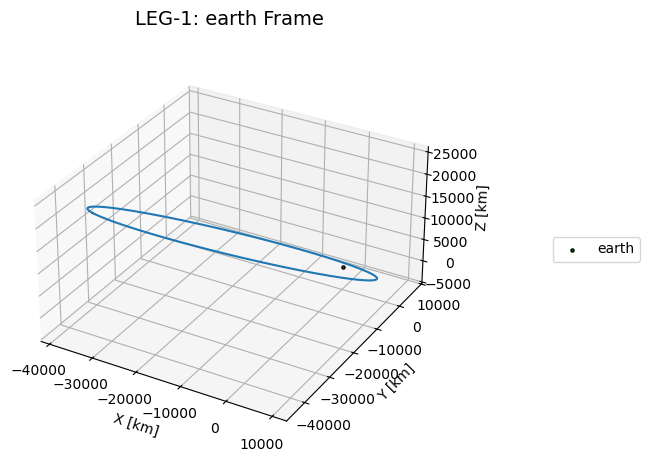

In [19]:
type(sat.r_ar)

numpy.ndarray

In [26]:
len(TrajExact)

35994089